In [5]:
import numpy as np
from cmeutils.sampling import is_equilibrated, equil_sample
import unyt as u
from unyt import Unit
import signac
import gsd.hoomd
import matplotlib.pyplot as plt

In [6]:
project = signac.get_project("../validation/")
job_filter = {"remove_hydrogens": True, "remove_charges": False, "pressure": 0.0013933}

In [7]:
project.detect_schema()

ProjectSchema(<len=19>)

/home/erjank_project/chrisjones/1-PPS-MSIBI/pps-msibi/validation/workspace/28087f6c5e62e692ffe6b1de1a642e69 1.3
/home/erjank_project/chrisjones/1-PPS-MSIBI/pps-msibi/validation/workspace/317cd6998cbc2880bf7c22994f9ac7f4 1.9
/home/erjank_project/chrisjones/1-PPS-MSIBI/pps-msibi/validation/workspace/a75323b65181087150927e1e77649150 2.4
/home/erjank_project/chrisjones/1-PPS-MSIBI/pps-msibi/validation/workspace/d3d61800dd0bbc013b833dddf67cbc5e 1.4
/home/erjank_project/chrisjones/1-PPS-MSIBI/pps-msibi/validation/workspace/2a1b91b6180297992da63e6b70935adc 1.5
/home/erjank_project/chrisjones/1-PPS-MSIBI/pps-msibi/validation/workspace/33e7ba171d1d4ddcca6a778d856ae50c 1.6
/home/erjank_project/chrisjones/1-PPS-MSIBI/pps-msibi/validation/workspace/6d7584175ba0c9c28175589604d8cb45 2.2
/home/erjank_project/chrisjones/1-PPS-MSIBI/pps-msibi/validation/workspace/243dcad9ce54062020d84bd126d93fa5 2.6
/home/erjank_project/chrisjones/1-PPS-MSIBI/pps-msibi/validation/workspace/859424371d74da5417e895b9c2356

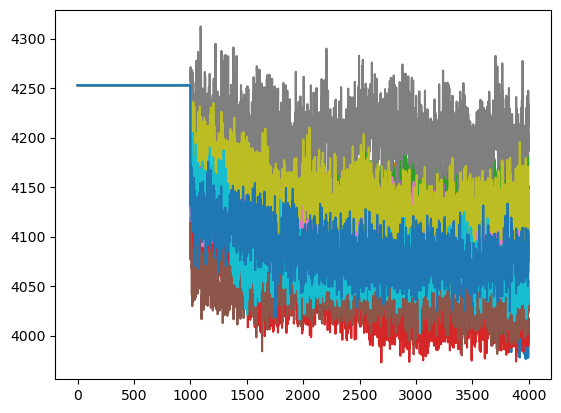

In [18]:
for job in project.find_jobs(filter=job_filter):
    data = np.genfromtxt(job.fn("log.txt"), names=True)
    temp = data["mdcomputeThermodynamicQuantitieskinetic_temperature"]
    vol = data["mdcomputeThermodynamicQuantitiesvolume"]
    pressure = data["mdcomputeThermodynamicQuantitiespressure"]
    #plt.plot(vol[3600:])
    #plt.plot(temp[3950:])
    plt.plot(vol[2000:])
    print(job.path, job.sp.kT)

In [14]:
for job in project.find_jobs(filter=job_filter):
    data = np.genfromtxt(job.fn("log.txt"), names=True)
    vol = data["mdcomputeThermodynamicQuantitiesvolume"]
    pe = data["mdcomputeThermodynamicQuantitiespotential_energy"]
    sample_idx = len(vol)//2
    vol_eq = is_equilibrated(vol[sample_idx:], threshold_fraction=0.10, threshold_neff=100)[0]
    pe_eq = is_equilibrated(pe[sample_idx:], threshold_fraction=0.10, threshold_neff=100)[0]
    print(vol_eq, pe_eq)
    print()

False True

False True

True True

True True

True True

True True

True True

True True

True True

False True

True True



In [13]:
for job in project.find_jobs(filter=job_filter):
    data = np.genfromtxt(job.fn("log.txt"), names=True)
    vol = data["mdcomputeThermodynamicQuantitiesvolume"]
    sample_idx = len(vol)//2
    uncorr_sample, uncorr_indices, prod_start, Neff = equil_sample(
        vol[sample_idx:], threshold_fraction=0.10, threshold_neff=100
    )
    vol_nm = uncorr_sample * (job.doc.ref_length**3) * Unit(f"{job.doc.ref_length_units}**3")
    vol_cm = vol_nm.to("cm**3")
    job.doc.avg_vol = np.mean(vol_cm.value)
    job.doc.vol_std = np.std(vol_cm.value)
    #np.savetxt(job.fn("vol_sample_indices.txt"), uncorr_indices + sample_idx)
    np.savetxt(job.fn("vol_cc.txt"), vol_cm.value)
    with gsd.hoomd.open(job.fn("restart.gsd")) as traj:
        snap = traj[0]
        reduced_mass = sum(snap.particles.mass)
        mass_amu = reduced_mass * job.doc.ref_mass * Unit(job.doc.ref_mass_units)
        mass_g = mass_amu.to("g")
        job.doc.mass_g = mass_g.value
    job.doc.avg_density = job.doc.mass_g / job.doc.avg_vol
    job.doc.density_std = job.doc.mass_g / job.doc.vol_std
    job.doc.volume_sampled = True

ValueError: Property does not have requisite threshold of production data expected. More production data is needed, or the threshold needs to be lowered. See is_equilibrated for more information.

In [ ]:
for kT, job in project.find_jobs(filter=job_filter).groupby("kT"):
    if kT < 1.1 or kT> 2.0: continue
    job = list(job)[0]
    print(kT, job.path)
    #print(kT, job.path)
    plt.plot(kT, job.doc.avg_density, "ko")
    #plt.vlines(x=1.67, ymin=0.68, ymax=0.72, ls="--", color="red")

In [ ]:
plt.plot(data["mdcomputeThermodynamicQuantitieskinetic_temperature"][-2000:])